# Amazon Food Reviews - [Logistic Regression]

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/NewCover.png)

## Excerpt 
1. Applied Logistic Regression on Different Featurization of Data viz. BOW(uni-gram,bi-gram), tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google News) and tf-idf-Word2Vec <br>
2. Used both Grid Search & Randomized Search Cross Validation <br>
3. Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix using seaborne<br>
4. Showed How Sparsity increases as we increase lambda or decrease C when L1 Regularizer is used for each featurization<br>
5. Did pertubation test to check whether the features are multi-collinear or not

#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/AmazonReview.png)


### Objective:- Review Polarity
Given a review, determine the review is positive or negative

#### Using text review to decide the polarity
Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative


In [6]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

### Loading the data

In [2]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [3]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [4]:
df.shape
df['Score'].size

364171

## For EDA and Text Preprecessing Refer other ipynb notebook<b>

In [5]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [6]:
#Taking Whole Data
df_sample = df

###Sorting as we want according to time series
df_sample.sort_values('Time',inplace=True) 
df_sample.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b'witty little book makes son laugh loud recit...
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,0,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...,b'remember seeing show aired television years ...
298792,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,0,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...,b'beetlejuice well written movie everything ex...
169281,212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,0,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...,b'twist rumplestiskin captured film starring m...
298791,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,0,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...,b'beetlejuice excellent funny movie keaton hil...
169342,212533,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,0,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...,b'one movie movie collection filled comedy act...
169267,212458,230269,B00004RYGX,A1B2IZU1JLZA6,Wes,19,23,1,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...,b'always enjoyed movie funny entertaining didn...
63317,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli hour trap mani...,b'bought apartment infested fruit flies hours ...
169367,212558,230376,B00004RYGX,ACJR7EQF9S6FP,Jeremy Robertson,2,3,0,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'happen say name three time michael keaten st...,b'happens say name three times michael keaten ...
169320,212511,230326,B00004RYGX,A2DEE7F9XKP3ZR,jerome,0,3,0,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazyim look beatlejuic french version v...,b'getting crazyim looking beatlejuice french v...


In [7]:
#Saving whole dataset in disk to as to test to test on the same sample for each of all Algo
savetofile(df_sample,"sample_lr")

In [7]:
#Opening from samples from file
df_sample = openfromfile("sample_lr")

# Logistic Regression Model on Reviews using Different Vectorizing Techniques in NLP

![img](http://songhuiming.github.io/figures/20170513_gradient_descent_logistic_animation.gif)

## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 161941)
Test Data Size:  (109252, 161941)


Observed that Data Normalization gives better accuracy rather than Data Standardization. <br>
Hence used Data Normalization

In [10]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(23179, 161941) (23174, 161941)
(46353, 161941) (23174, 161941)
(69527, 161941) (23174, 161941)
(92701, 161941) (23174, 161941)
(115875, 161941) (23174, 161941)
(139049, 161941) (23174, 161941)
(162223, 161941) (23174, 161941)
(185397, 161941) (23174, 161941)
(208571, 161941) (23174, 161941)
(231745, 161941) (23174, 161941)


![image.png](attachment:image.png)

### Finding the best "C" or "1/lambda" and regularizer [ L1 or L2 ] using Forward Chaining Cross Validation or Time Series CV 

In [11]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_uni")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 33.8min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 92.16%


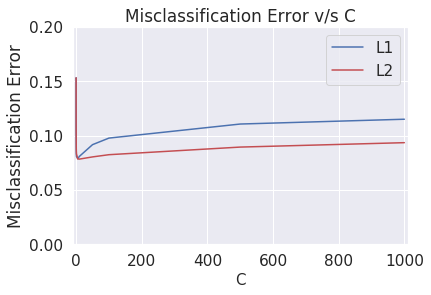

In [99]:
def plot_error_vs_c(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
gsv = openfromfile("Log Reg/gsv_uni")
plot_error_vs_c(gsv)

Accuracy on test set: 91.957%
Precision on test set: 0.824
Recall on test set: 0.686
F1-Score on test set: 0.749
Non Zero weights: 161941
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



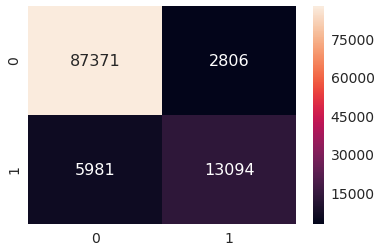

In [93]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.024%
F1-Score on test set: 0.670
Non Zero weights: 59300


In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.486%
F1-Score on test set: 0.713
Non Zero weights: 37996


In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.737%
F1-Score on test set: 0.745
Non Zero weights: 13255


In [16]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.801%
F1-Score on test set: 0.741
Non Zero weights: 2183


In [17]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.504%
F1-Score on test set: 0.678
Non Zero weights: 506


In [18]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.692%
F1-Score on test set: 0.358
Non Zero weights: 76


<b> We can see how drastically the sparsity increases from 59300 non-zero weights(@ C=1000) to only 76 non-zero weights(@ C=0.01) when we use L1 Regularization</b>

#### Using Randomized Search CV to find best parameters

In [19]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_uni_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.9min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 5}
Best Accuracy: 92.14%


Accuracy on test set: 91.961%
Precision on test set: 0.827
Recall on test set: 0.682
F1-Score on test set: 0.748
Non Zero weights: 161941
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



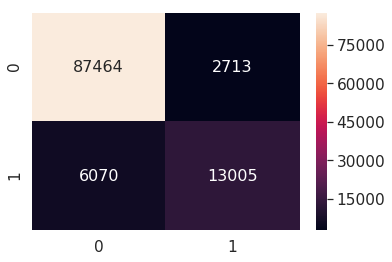

In [79]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

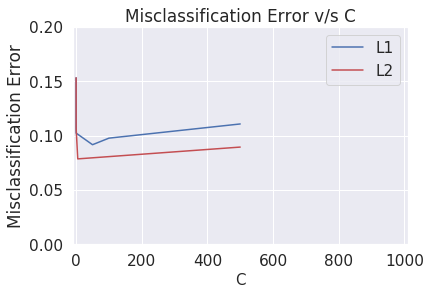

In [102]:
#Function to plot Misclassification error against C
def plot_error_vs_c_r(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])

    ind1 = np.argsort(x1)
    x1=np.array(x1)
    y1=np.array(y1)
    ind2 = np.argsort(x2)
    x2=np.array(x2)
    y2=np.array(y2)
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1[ind1],y1[ind1],'b',label="L1")
    plt.plot(x2[ind2],y2[ind2],'r',label="L2")
    plt.legend()
    plt.show()
gsv = openfromfile("Log Reg/gsv_uni_r")
plot_error_vs_c_r(gsv)

## Perturbation Test

In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.957%
Non Zero weights: 161941


In [22]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 1.62127418e-01 -8.73158176e-01 -8.07503760e-04 -3.91387262e-03
 -6.26736551e-04 -3.25885599e-02 -1.36001313e-03  2.85661329e-01
 -4.12454323e-04 -2.15735105e-02  4.38742992e-02 -2.15735105e-02
 -1.36001313e-03 -9.33725979e-02 -7.46744986e-03 -6.07793331e-02
 -4.92971516e-02 -3.05447698e-02 -1.12805405e-02 -8.07973023e-02
 -6.03323191e-02 -5.50761134e-02 -1.42545278e-01 -2.74150204e-02
 -1.62669102e-03 -2.55688907e-04  1.54831373e+00 -1.24441965e-02
 -1.36334749e-03 -6.40588018e-04 -7.10697191e-02 -2.62238833e-03
 -6.06739388e-02 -5.11612900e-02 -5.48579511e-01 -1.01264312e-02
 -1.32553267e-02 -3.96700298e-01  4.00558464e-01 -2.15666045e-01
 -1.02556687e-02 -1.39019009e-02  6.72291453e-02 -1.83060882e-02
 -3.25580379e-01 -1.06265045e-01 -7.04401304e-04 -5.32989079e-03
 -6.23608650e-01 -1.54185650e-01]


In [23]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [24]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.956%
Non Zero weights: 161941


In [25]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 1.63372510e-01 -8.74335321e-01 -8.07716028e-04 -3.91545655e-03
 -6.23742983e-04 -3.24461680e-02 -1.38162506e-03  2.84683660e-01
 -4.22492124e-04 -2.14915893e-02  4.39026865e-02 -2.14745335e-02
 -1.38251527e-03 -9.26594859e-02 -7.44544825e-03 -6.08867219e-02
 -4.94163470e-02 -3.05814479e-02 -1.12499198e-02 -8.05772877e-02
 -6.03523479e-02 -5.46456693e-02 -1.42199830e-01 -2.75188339e-02
 -1.62325145e-03 -2.56413499e-04  1.55056201e+00 -1.24417603e-02
 -1.35619217e-03 -6.38673401e-04 -7.06393005e-02 -2.64083718e-03
 -6.03076839e-02 -5.09226535e-02 -5.48356816e-01 -1.00820452e-02
 -1.31744425e-02 -3.95184899e-01  3.97059620e-01 -2.15083177e-01
 -1.03022561e-02 -1.38487694e-02  6.71626766e-02 -1.82406373e-02
 -3.24491329e-01 -1.06131700e-01 -7.04801762e-04 -5.30489791e-03
 -6.21503278e-01 -1.53887667e-01]


In [26]:
print(weights2.size)

161941


In [27]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [28]:
print(weights_diff[np.where(weights_diff > 30)].size)

42


 <b>42 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

#### Feature Importance[Top 25]

##### The coef_ attribute of MultinomialNB is a re-parameterization of the naive Bayes model as a linear classifier model. For a binary classification problems this is basically the log of the estimated probability of a feature given the positive class. It means that higher values mean more important features for the positive class.

In [29]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(uni_gram,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-11.8734	skeptic        				17.2728	worst          
	-10.4405	downsid        				12.9641	undrink        
	-10.4112	hook           				11.7766	aw             
	-9.9261	delici         				11.0051	terribl        
	-9.5487	perfect        				10.8843	threw          
	-9.4283	beat           				10.8481	tasteless      
	-9.4144	addict         				10.8416	flavorless     
	-9.0986	excel          				10.6707	disgust        
	-9.0159	amaz           				10.6475	yuck           
	-8.8969	worri          				10.4184	horribl        
	-8.7746	awesom         				10.2898	unaccept       
	-8.6804	drawback       				9.7485	mediocr        
	-8.5025	yum            				9.6643	unpleas        
	-8.3525	fantast        				9.4898	unapp          
	-8.2334	uniqu          				9.4861	redeem         
	-8.2270	yummi          				9.4289	decept         
	-8.1240	terrif         				9.3635	ined        

### bi-gram

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 2642089)
Test Data Size:  (109252, 2642089)


In [31]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 73.8min finished


Best HyperParameter:  {'C': 100, 'penalty': 'l2'}
Best Accuracy: 93.42%


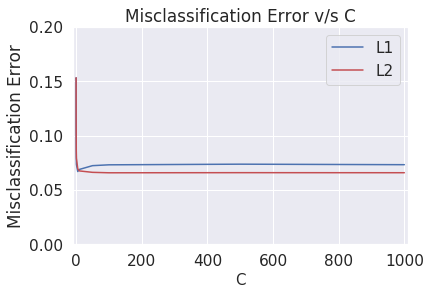

In [100]:
gsv = openfromfile("Log Reg/gsv_bi")
plot_error_vs_c(gsv)

Accuracy on test set: 93.704%
Precision on test set: 0.864
Recall on test set: 0.759
F1-Score on test set: 0.808
Non Zero weights: 2642089
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



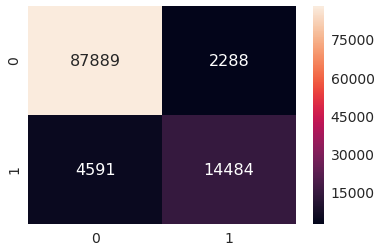

In [90]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [33]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.918%
F1-Score on test set: 0.790
Non Zero weights: 52309


In [34]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.997%
F1-Score on test set: 0.793
Non Zero weights: 39903


In [35]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.382%
F1-Score on test set: 0.802
Non Zero weights: 25690


In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.056%
F1-Score on test set: 0.784
Non Zero weights: 2516


In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.946%
F1-Score on test set: 0.693
Non Zero weights: 433


In [38]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.974%
F1-Score on test set: 0.301
Non Zero weights: 55


<b> We can see how drastically the sparsity increases from 52309 non-zero weights(@ C=1000) to only 55 non-zero weights(@ C=0.01) when we use L1 Regularization</b>

#### Using Randomized Search CV to find best parameters

In [39]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_bi_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 25.8min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 100}
Best Accuracy: 93.42%


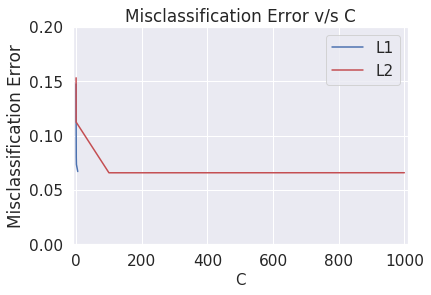

In [103]:
gsv = openfromfile("Log Reg/gsv_bi_r")
plot_error_vs_c_r(gsv)

Accuracy on test set: 93.704%
Precision on test set: 0.864
Recall on test set: 0.759
F1-Score on test set: 0.808
Non Zero weights: 2642089
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



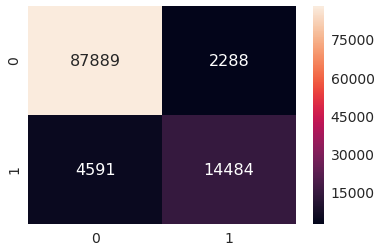

In [91]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Perturbation Test

In [41]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.676%
Non Zero weights: 2642089


In [42]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[-1.01381496e-01 -3.44469688e-01  2.44035373e-01 -9.47181393e-04
 -1.68280020e+00 -1.20072827e+00 -2.70055377e-02  1.98429026e-01
 -1.19593162e-01 -2.31058228e-02 -2.83857519e-03 -2.04210949e-02
 -3.86809371e-01 -2.18367029e-04 -4.32643431e-03 -4.32643431e-03
 -9.50019770e-05 -9.50019770e-05 -3.35809220e-02 -1.44446943e-03
 -1.44446943e-03  3.32859146e-01  3.32859146e-01 -7.54598786e-04
 -7.54598786e-04 -4.56512291e-02 -4.56512291e-02  1.68773846e-01
  1.68773846e-01 -4.56512291e-02 -4.56512291e-02 -1.44446943e-03
 -1.44446943e-03 -1.82834818e-02 -2.99012527e-03 -1.52933565e-02
 -3.38319255e-02 -3.38319255e-02 -1.60506041e-01 -1.60506041e-01
 -5.40262643e-02 -3.33134673e-02 -2.07127970e-02 -6.18306988e-02
 -6.18306988e-02 -7.01089637e-03 -7.01089637e-03 -3.22684159e-02
 -6.31367354e-03 -2.59547423e-02]


In [43]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [44]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.606%
Non Zero weights: 2642089


In [45]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[-4.33813144e-02 -1.00695847e-01  5.84981108e-02 -1.10051854e-03
 -6.11857829e-01 -4.38142949e-01 -1.34566823e-02  8.63908112e-02
 -3.84090523e-02 -8.75382816e-03 -3.57847644e-03 -6.23946463e-03
 -1.45135843e-01 -3.35285733e-04 -5.79425293e-03 -5.79295392e-03
 -1.32060675e-04 -1.32192263e-04 -1.72134251e-02 -2.21565680e-03
 -2.21303764e-03  1.37052778e-01  1.37215661e-01 -8.07074566e-04
 -8.07557104e-04 -1.37366994e-02 -1.37046406e-02  4.33807189e-02
  4.33717187e-02 -1.36908211e-02 -1.37432450e-02 -2.21408164e-03
 -2.21138238e-03 -1.77322000e-02 -4.16476796e-03 -1.35808041e-02
 -1.57372118e-02 -1.57323897e-02 -5.37406508e-02 -5.36399563e-02
 -2.45457480e-02 -1.81597843e-02 -6.37913712e-03 -3.44245070e-02
 -3.43598796e-02 -7.41791250e-03 -7.41595034e-03 -2.32205834e-02
 -4.11297910e-03 -1.91035666e-02]


In [46]:
print(weights2.size)

2642089


In [47]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [48]:
print(weights_diff[np.where(weights_diff > 30)].size)

526050


 <b>526050 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

#### Feature Importance[Top 25]

In [49]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bi_gram,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-22.0535	not disappoint 				19.4132	worst          
	-15.3538	wont disappoint				18.6620	two star       
	-13.3869	high recommend 				18.1772	not worth      
	-12.8412	delici         				15.9291	not recommend  
	-11.7429	not overpow    				14.5988	disappoint     
	-11.5075	four star      				13.9818	aw             
	-11.4392	perfect        				13.4736	terribl        
	-11.4001	hook           				13.2728	not happi      
	-10.8706	skeptic        				13.0714	wont buy       
	-10.8630	never disappoint				12.5681	horribl        
	-10.8142	excel          				12.5637	not impress    
	-10.6494	pleasant surpris				12.5410	not good       
	-10.5116	amaz           				12.3250	want like      
	-10.5004	not bitter     				12.2989	threw          
	-10.4878	addict         				12.2914	tasteless      
	-10.3002	not bad        				12.2731	disgust        
	-10.1454	awesom         		

# tf-idf


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11181616/image-4.png)

In [50]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 2642089)
Test Data Size:  (109252, 2642089)
CPU times: user 54.7 s, sys: 320 ms, total: 55 s
Wall time: 55 s


In [51]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_tfidf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 52.0min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l1'}
Best Accuracy: 93.28%


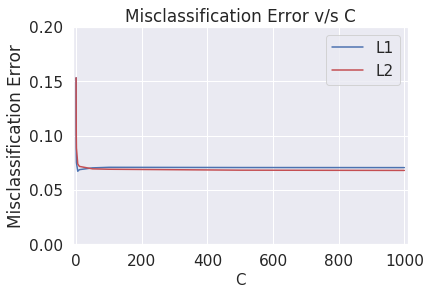

In [101]:
gsv = openfromfile("Log Reg/gsv_tfidf")
plot_error_vs_c(gsv)

Accuracy on test set: 93.615%
Precision on test set: 0.848
Recall on test set: 0.773
F1-Score on test set: 0.809
Non Zero weights: 19635
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



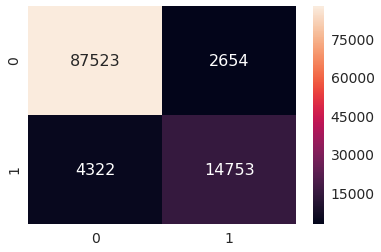

In [52]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [53]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.156%
F1-Score on test set: 0.796
Non Zero weights: 62771


In [54]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.138%
F1-Score on test set: 0.797
Non Zero weights: 44278


In [55]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.416%
F1-Score on test set: 0.804
Non Zero weights: 30964


In [56]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.104%
F1-Score on test set: 0.787
Non Zero weights: 2533


In [57]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.484%
F1-Score on test set: 0.669
Non Zero weights: 334


In [58]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 83.202%
F1-Score on test set: 0.097
Non Zero weights: 20


<b> We can see how drastically the sparsity increases from 62771 non-zero weights(@ C=1000) to only 20 non-zero weights(@ C=0.01) when we use L1 Regularization</b>

#### Using Randomized Search CV to find best parameters

In [59]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_tfidf_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 19.3min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 5}
Best Accuracy: 93.28%


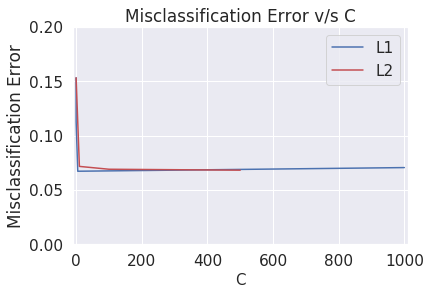

In [104]:
gsv = openfromfile("Log Reg/gsv_tfidf_r")
plot_error_vs_c_r(gsv)

Accuracy on test set: 93.616%
Precision on test set: 0.848
Recall on test set: 0.774
F1-Score on test set: 0.809
Non Zero weights: 19631
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



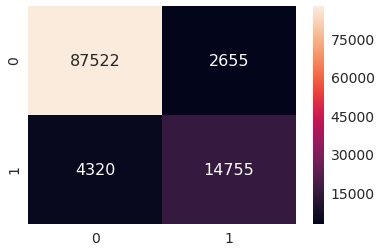

In [60]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Perturbation Test

In [61]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.745%
Non Zero weights: 2642089


In [62]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 1.54080710e-03 -3.96274735e-01  3.98983503e-01 -1.07942113e-03
 -1.61670704e+00 -1.44771472e+00 -3.19720938e-02  3.84732304e-01
 -1.17866003e-01 -2.77511970e-02 -4.14339254e-03 -2.18484062e-02
 -4.46350671e-01 -8.82459806e-04 -3.08634112e-02 -3.08634112e-02
 -3.88698669e-04 -3.88698669e-04 -2.67661468e-02 -6.48672736e-03
 -6.48672736e-03  4.53869653e-01  4.53869653e-01 -3.15352996e-03
 -3.15352996e-03 -5.51731390e-02 -5.51731390e-02  1.91382622e-01
  1.91382622e-01 -5.51731390e-02 -5.51731390e-02 -6.48672736e-03
 -6.48672736e-03 -4.39183012e-02 -5.92446541e-03 -3.94357147e-02
 -7.12245945e-02 -7.12245945e-02 -1.63653191e-01 -1.63653191e-01
 -1.02440866e-01 -9.61034513e-02 -9.70064463e-03 -1.14747661e-01
 -1.14747661e-01 -1.59915729e-02 -1.59915729e-02 -3.90206534e-02
 -6.53047153e-03 -3.37712665e-02]


In [63]:
print(weights1[weights1<=0.0001])

[-3.96274735e-01 -1.07942113e-03 -1.61670704e+00 ... -1.09323668e-01
 -3.75148001e-02 -3.75148001e-02]


In [64]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [65]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 93.623%
Non Zero weights: 2642089


In [66]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[-8.60180184e-03 -1.26060557e-01  1.18387709e-01 -1.34565630e-03
 -5.91620645e-01 -4.87686020e-01 -2.32940297e-02  1.40615368e-01
 -4.60732329e-02 -1.46520416e-02 -5.77394510e-03 -1.08874349e-02
 -1.66347746e-01 -1.07553469e-03 -2.42159849e-02 -2.42229359e-02
 -3.55607661e-04 -3.55347345e-04 -2.28078076e-02 -7.88529599e-03
 -7.87615795e-03  1.83719353e-01  1.83849844e-01 -4.11961452e-03
 -4.11941236e-03 -1.84312632e-02 -1.84116871e-02  6.07085060e-02
  6.07277979e-02 -1.83906190e-02 -1.84380576e-02 -7.87814498e-03
 -7.88748449e-03 -3.83769109e-02 -7.12391388e-03 -3.25250846e-02
 -3.10689025e-02 -3.10911844e-02 -6.11908573e-02 -6.11244434e-02
 -4.74109239e-02 -4.31481547e-02 -5.80580998e-03 -4.75875700e-02
 -4.76080447e-02 -1.44740225e-02 -1.44867049e-02 -3.00457318e-02
 -5.48654741e-03 -2.55454432e-02]


In [67]:
print(weights2.size)

2642089


In [68]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [69]:
print(weights_diff[np.where(weights_diff > 30)].size)

531188


 <b>531188 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

#### Feature Importance[Top 25]

In [70]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-26.2316	great          				24.3664	disappoint     
	-23.6295	delici         				22.6211	worst          
	-21.6326	best           				19.0296	not worth      
	-21.5289	not disappoint 				17.1721	not recommend  
	-20.4887	love           				17.0111	aw             
	-20.0666	perfect        				17.0020	terribl        
	-18.1351	good           				16.1959	two star       
	-17.5381	excel          				16.0429	not good       
	-16.3522	high recommend 				15.8967	horribl        
	-14.8252	happi          				14.4583	threw          
	-14.8140	amaz           				14.3036	not buy        
	-14.2826	wont disappoint				14.0162	return         
	-14.1085	tasti          				13.9427	unfortun       
	-14.1077	nice           				13.9045	wont buy       
	-13.8460	favorit        				13.8349	bland          
	-12.9218	addict         				13.6785	disgust        
	-12.8887	awesom         				

## Gensim
Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

## Word2Vec
[Refer Docs] :https://radimrehurek.com/gensim/models/word2vec.html 

In [71]:
from gensim.models import KeyedVectors

#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [72]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

3000000

## Avg Word2Vec
* One of the most naive but good ways to convert a sentence into a vector
* Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 

In [94]:
%%time
avg_vec_google = [] #List to store all the avg w2vec's 
# no_datapoints = 364170
# sample_cols = random.sample(range(1, no_datapoints), 20001)
for sent in df_sample['CleanedText_NoStem']:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt #Taking average of vectors sum of the particular review
#     print("avg_vec:",sent_vec)
    avg_vec_google.append(sent_vec) #Storing the avg w2vec's for each review
#     print("*******************************************************************")
# print(avg_vec_google)
avg_vec_google = np.array(avg_vec_google)

CPU times: user 3min 15s, sys: 272 ms, total: 3min 16s
Wall time: 3min 16s


In [95]:
np.isnan(avg_vec_google).any()

True

In [96]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = df_sample['Score'][mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(364167, 300)
(364167,)


In [97]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#Normalizing the data
avg_vec_norm = preprocessing.normalize(avg_vec_google_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample_new.values,test_size=0.3,shuffle=False)

In [77]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_w2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 132.4min finished


Best HyperParameter:  {'C': 1000, 'penalty': 'l2'}
Best Accuracy: 89.96%


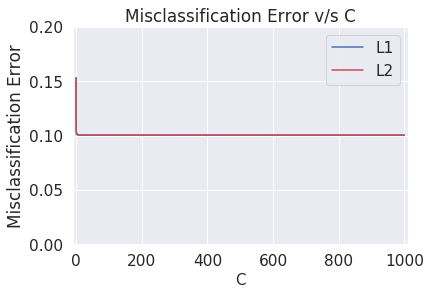

In [105]:
gsv = openfromfile("Log Reg/gsv_w2v")
plot_error_vs_c(gsv)

Accuracy on test set: 89.280%
Precision on test set: 0.778
Recall on test set: 0.540
F1-Score on test set: 0.638
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



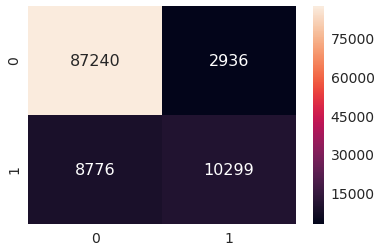

In [98]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Using Randomized Search CV to find best parameters

In [79]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_w2v_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 59.7min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1000}
Best Accuracy: 89.96%


Accuracy on test set: 89.264%
Precision on test set: 0.778
Recall on test set: 0.538
F1-Score on test set: 0.637
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



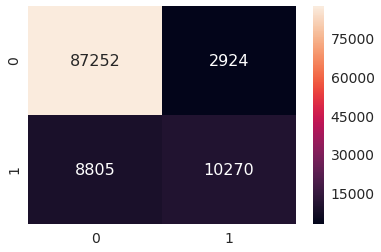

In [80]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

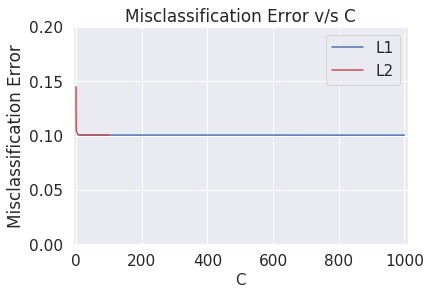

In [107]:
gsv = openfromfile("Log Reg/gsv_w2v_r")
plot_error_vs_c_r(gsv)

## Perturbation Test

In [81]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.264%
Non Zero weights: 300


In [82]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 2.93310325 -0.99805544  5.2099798  -0.05418424 -1.23858575  0.51400316
  0.77469816  1.25851324 -0.41195786 -2.86481359  2.24151288 -2.16234163
 -2.53379535 -0.1991284  -1.15832793  0.03067626 -0.97988392 -2.29218165
  0.09423808 -3.60958852 -3.13134885  5.44384896 -2.61325668 -1.81127643
  1.76272361  3.45727533  4.88736986  1.66774396  1.70378583 -0.25755958
 -0.89468301  0.04260589 -7.87516811 -1.00904625 -1.9562949  -1.84516546
  1.12239244  4.24194222 -3.86296245 -1.09664441  0.75320908  3.98452737
  2.83465387 -5.22237633  0.03432929 -5.70089577 -1.14298246  2.3224955
 -4.94992187 -1.31871693]


In [83]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [84]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.219%
Non Zero weights: 300


In [85]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 3.020755   -0.75223805  4.99187761  0.07041392 -1.40612523  0.67313287
  0.64545153  0.97639123 -0.07283472 -2.4143386   1.71416283 -2.00124253
 -2.35278349  0.03766044 -0.93049977  0.25906514 -1.16299813 -2.57683921
  0.218417   -3.08578289 -2.89364611  4.73114163 -2.27438914 -1.89787466
  1.70029789  3.02279279  4.7329153   1.49704309  1.57483397 -0.12869559
 -0.74798705 -0.26924469 -6.95405205 -1.31848504 -1.82482903 -1.78980172
  1.46249277  3.69194971 -3.34534328 -0.92021319  0.49116143  3.35538645
  2.54903383 -4.77773194  0.05762255 -5.39411889 -0.9664828   2.08828778
 -4.66873276 -1.07345728]


In [86]:
print(weights2.size)

300


In [87]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [88]:
print(weights_diff[np.where(weights_diff > 30)].size)

32


 <b>32 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [220]:
%%time
###tf-idf with No Stemming
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.sparse import vstack

#Taking sample of only 25k points as it takes a huge amount of time ot compute 
n_samples = 25000
df_sample_new = df_sample.sample(n_samples)
X_train, X_test, y_train, y_test = train_test_split(df_sample_new['CleanedText_NoStem'].values,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
tfidf_vec_train = tfidf.fit_transform(X_train)
tfidf_vec_test = tfidf.transform(X_test)
print(tfidf_vec_train.shape)
print(tfidf_vec_test.shape)

#Concatenating sparse matrix vertically
tfidf_vec_new = vstack((tfidf_vec_train,tfidf_vec_test))
print(tfidf_vec.shape)
features = tfidf.get_feature_names()

In [219]:
savetofile(df_sample_new,"df_sample_new_tfidfw2vec")

In [179]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in df_sample_new['CleanedText_NoStem'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("w2vec:",wvec)
#             print("tfidf:",tfidf_vec_new[review,features.index(word)])
            tfidf_vec = tfidf_vec_new[review,features.index(word)]
            sent_vec += (wvec * tfidf_vec)
            weighted_sum += tfidf_vec
        except:
#             print(review)
            pass
    sent_vec /= weighted_sum
#     print(sent_vec)
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
savetofile(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")

CPU times: user 4h 22min 47s, sys: 1.29 s, total: 4h 22min 48s
Wall time: 4h 22min 50s


In [6]:
#Precomputed File
tfidf_w2v_vec_google = openfromfile("tfidf_w2v_vec_google")
#Loading the same samples as using precomuted file
df_sample_new = openfromfile("df_sample_new_tfidfw2vec")

In [7]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

In [9]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_w2vtfidf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  5.3min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 87.74%


Accuracy on test set: 88.027%
Precision on test set: 0.718
Recall on test set: 0.426
F1-Score on test set: 0.535
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



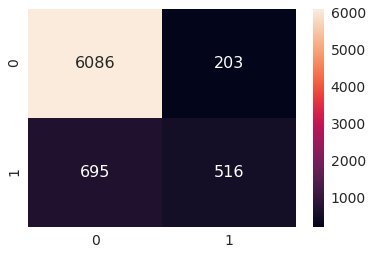

In [10]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

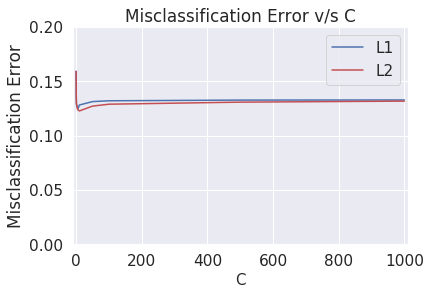

In [108]:
gsv = openfromfile("Log Reg/gsv_w2vtfidf")
plot_error_vs_c(gsv)

#### Using Randomized Search CV to find best parameters

In [11]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_w2vtfidf_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   45.7s finished


Best HyperParameter:  {'penalty': 'l2', 'C': 5}
Best Accuracy: 87.62%


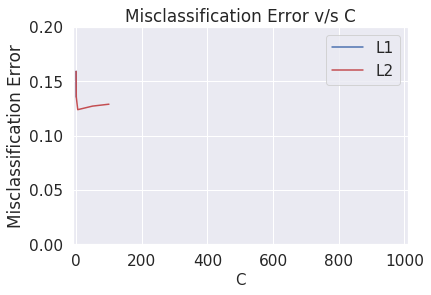

In [111]:
gsv = openfromfile("Log Reg/gsv_w2vtfidf_r")
plot_error_vs_c_r(gsv)

Accuracy on test set: 88.093%
Precision on test set: 0.730
Recall on test set: 0.417
F1-Score on test set: 0.531
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



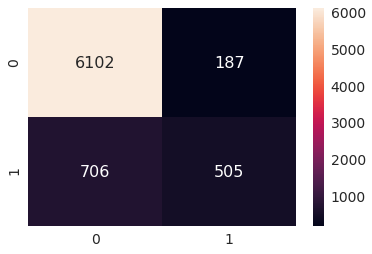

In [12]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Perturbation Test

In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.093%
Non Zero weights: 300


In [14]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 3.09833264  1.71877671  4.1910419   0.16948281 -2.51650263  0.97363792
  0.07545685  0.22968972  0.73408894 -1.95530632 -0.60414757 -1.26794617
 -2.10640391 -0.36362473 -0.61648283  0.52306904  1.65465016 -0.58501853
 -1.79683178 -2.16297357 -2.16604762  4.12177713 -1.37578184 -1.10562501
  2.02520228  2.75247428  2.49485315  1.75012345  1.55628488  1.71847199
  0.0883383   0.36437432 -4.2428553  -3.40183532 -0.88014657 -0.69008009
  1.0430904   1.92841751 -2.4879832  -2.15374739 -1.41698259  2.28910169
  2.10898808 -4.8160896   1.61361961 -4.61280952 -1.53836733  1.08892048
 -2.10653221 -0.45505328]


In [15]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [16]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.027%
Non Zero weights: 300


In [17]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 3.32838336  1.90457789  4.45955492  0.32829048 -2.66787529  0.94053152
 -0.01029601  0.28001717  0.65163589 -2.31210287 -0.61397089 -1.31442398
 -2.27410277 -0.42309511 -0.62814486  0.56756261  1.87582614 -0.53045354
 -2.12024237 -2.37756371 -2.43482472  4.66602472 -1.50530767 -1.0140527
  2.1984322   3.16269341  2.42805536  2.19926483  1.67798132  1.89445072
  0.12091103  0.50538028 -4.81743051 -3.57894275 -1.069279   -0.96477577
  0.94821608  2.10210871 -2.72352359 -2.43899051 -1.64348014  2.63331763
  2.2484728  -5.40365007  1.78490274 -5.18572779 -1.91863671  1.03914078
 -2.18315449 -0.48005497]


In [18]:
print(weights2.size)

300


In [19]:
weights_diff = (abs(weights2 - weights1)/weights1) * 100

In [20]:
print(weights_diff[np.where(weights_diff > 30)].size)

24


 <b>24 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

## Performance Table

![a](https://image.ibb.co/eMUTjJ/4_Logistic_Regression_Table.png)

## Conclusion
1. Features are multi-collinear i.e. they are co-related<br>
2. Bigram Featurization performs best with accuracy of 93.704 and F1-Score of 0.808<br>
3. Sparsity increases as we increase lambda or decrease C when L1 Regularizer is used<br>
4. Algorithms like SVM & Logistic Regression performed best on this data